In [440]:
import pandas as pd

frequency = 'annual'

# Read Statistics Canada formatted data
strikeCountsDf = pd.read_csv(f"data/{frequency}/strikes/strike-count.csv")
strikeAverageDurationsDf = pd.read_csv(f"data/{frequency}/strikes/strike-average-duration.csv")
strikeDaysNotWorkedDf = pd.read_csv(f"data/{frequency}/strikes/strike-days-not-worked.csv")

# Read FRED Data
unemploymentDf = pd.read_csv(f"data/{frequency}/unemployment.csv")
realGdpDf = pd.read_csv(f"data/{frequency}/real-gdp.csv")
inflationDf = pd.read_csv(f"data/{frequency}/inflation.csv")
populationDf = pd.read_csv(f"data/{frequency}/population.csv")

# Read Labour Share Data
# Household Compensation is Statistics Canada data, but it has been modified in Excel to have years as the dates
householdCompensationDf = pd.read_csv(f"data/{frequency}/labour-share/household-compensation.csv")

# Nominal GDP is Fred data
nominalGdpDf = pd.read_csv(f"data/{frequency}/labour-share/nominal-gdp.csv")

In [441]:
# Cleaning data
# Convert all FRED dates to the just a year
def convertToYears(date):
    return int(date[:4])

fredDfs = [unemploymentDf, realGdpDf, inflationDf, populationDf, nominalGdpDf]

for df in fredDfs:
    df['DATE'] = df['DATE'].apply(convertToYears)

# Rename datasets and drop unnecessary rows
strikeCountsDf = strikeCountsDf.rename(columns={'VALUE': 'strikeCounts'})
strikeAverageDurationsDf = strikeAverageDurationsDf.rename(columns={'VALUE': 'strikeAverageDurations'})
strikeDaysNotWorkedDf = strikeDaysNotWorkedDf.rename(columns={'VALUE': 'strikesDaysNotWorked'})

householdCompensationDf = householdCompensationDf.rename(columns={'VALUE': 'householdCompensation'})
nominalGdpDf = nominalGdpDf.rename(columns={'NGDPXDCCAA': 'nominalGdp'})

realGdpDf = realGdpDf.rename(columns={'NGDPRXDCCAA': 'realGdp'})
unemploymentDf = unemploymentDf.rename(columns={'LRUNTTTTCAA156S': 'unemploymentRate'})
inflationDf = inflationDf.rename(columns={'FPCPITOTLZGCAN': 'inflationRate'})
populationDf = populationDf.rename(columns={'POPTOTCAA647NWDB': 'population'})


In [442]:
# Merge into one dataframe
allDfs = [strikeCountsDf, strikeAverageDurationsDf, strikeDaysNotWorkedDf, unemploymentDf, realGdpDf, inflationDf, populationDf, householdCompensationDf, nominalGdpDf]

fullDf = strikeCountsDf

for df in allDfs[1:]:
    fullDf = pd.merge(fullDf, df, on='DATE')
    
fullDf = fullDf.rename(columns={'DATE': 'year'})

In [443]:
import numpy as np

# Create all variables
# Create labour share variable
fullDf['labourShare'] = fullDf['householdCompensation'] / fullDf['nominalGdp']

# Make strike counts and days not worked due to strikes relative to 1 000 000 people, to adjust for population size
# Strike duration does not need to be adjusted for this, as it is measuring time
peopleRatioForStrikes = 100000

fullDf['strikeCounts'] = (fullDf['strikeCounts'] / fullDf['population']) * peopleRatioForStrikes
fullDf['strikesDaysNotWorked'] = (fullDf['strikesDaysNotWorked'] / fullDf['population']) * peopleRatioForStrikes

# Create *approximated* growth rate in real GDP
# Uses log differences and the Taylor Series to approximate the growth rate 
fullDf['realGdpGrowthRate'] = np.log(fullDf['realGdp'])
fullDf['realGdpGrowthRate'] =  fullDf['realGdpGrowthRate'].diff()

# Create change in unemployment variable
fullDf['unemploymentRateChange'] = fullDf['unemploymentRate'].diff()

# Create dummy variable for inflation targeting period
targetingStartYear = 1991

fullDf['inflationTargetingPeriod'] = fullDf['year'] > targetingStartYear

fullDf['inflationRate_L1'] = fullDf['inflationRate'].shift(1)

# Drop first row since it is now empty (1962 is the first year now)
fullDf = fullDf.drop(index=[0])

# Drop unneeded columns
fullDf = fullDf.drop(columns=['nominalGdp', 'householdCompensation', 'realGdp'])

In [444]:
# Convert % data to larger numbers for easier interpretation
fullDf['labourShare'] = fullDf['labourShare'] * 100
fullDf['realGdpGrowthRate'] = fullDf['realGdpGrowthRate'] * 100

In [445]:
import statsmodels.formula.api as smf

strikeVariableNames = ['strikeCounts', 'strikesDaysNotWorked', 'strikeAverageDurations']

for variableName in strikeVariableNames:
    strikesFormula = f"{variableName} ~ inflationRate + inflationRate_L1 + inflationRate: inflationTargetingPeriod + inflationRate_L1: inflationTargetingPeriod + unemploymentRate + unemploymentRateChange + labourShare + realGdpGrowthRate + inflationTargetingPeriod"
    strikesModel = smf.ols(formula=strikesFormula, data=fullDf).fit()
    
    print(f"{variableName} Model\n")
    print(f"{strikesModel.summary()}\n")

strikeCounts Model

                            OLS Regression Results                            
Dep. Variable:           strikeCounts   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     64.78
Date:                Fri, 02 Aug 2024   Prob (F-statistic):           4.27e-25
Time:                        23:34:47   Log-Likelihood:                -27.983
No. Observations:                  62   AIC:                             75.97
Df Residuals:                      52   BIC:                             97.24
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

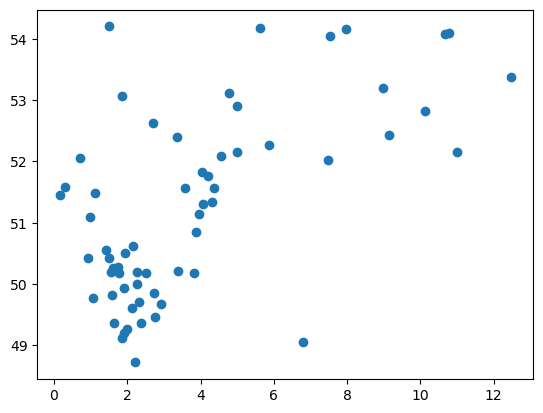

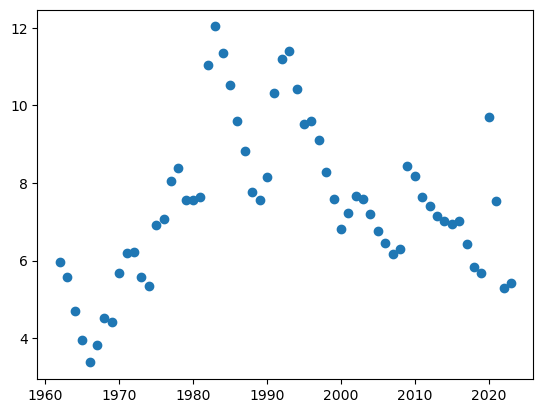

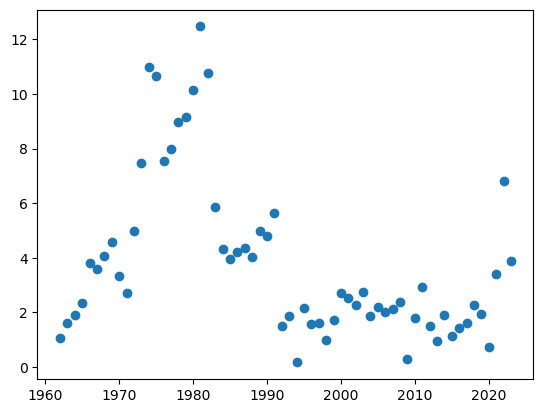

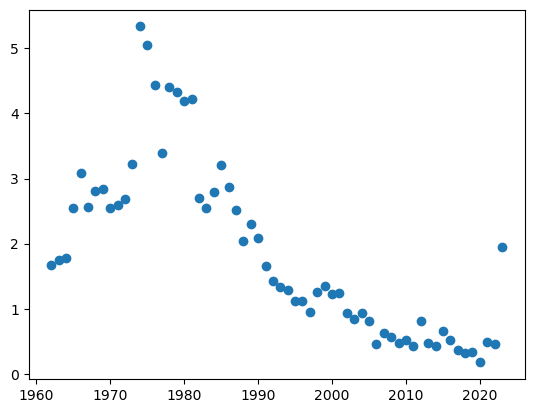

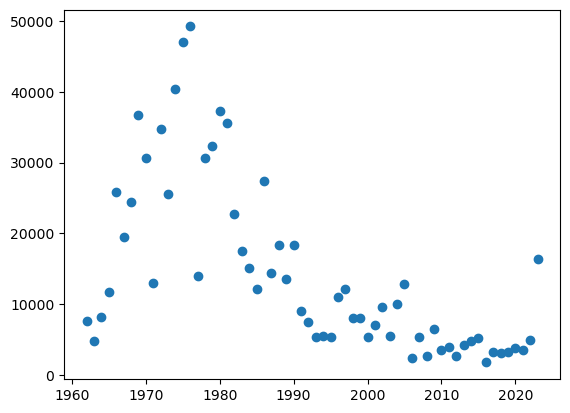

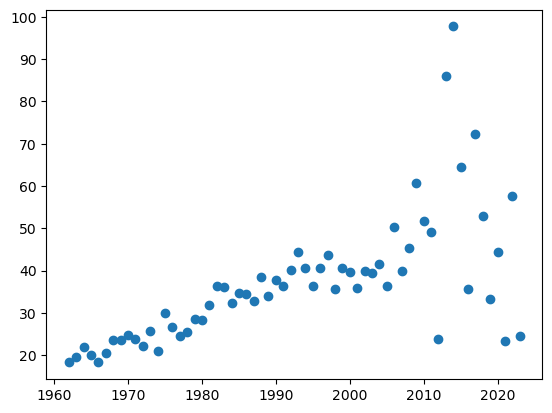

In [446]:
import matplotlib.pyplot as plt

# Note to self: comment out 

# Labour share vs inflation rate
plt.scatter(fullDf['inflationRate'], fullDf['labourShare'])
plt.show()

# Unemployment rate vs year
plt.scatter(fullDf['year'], fullDf['unemploymentRate'])
plt.show()

# Inflation rate vs year
plt.scatter(fullDf['year'], fullDf['inflationRate'])
plt.show()

# Strikes occurrences vs year
plt.scatter(fullDf['year'], fullDf['strikeCounts'])
plt.show()

# Strike days not worked vs year
plt.scatter(fullDf['year'], fullDf['strikesDaysNotWorked'])
plt.show()

# Average duration of a strike vs year
plt.scatter(fullDf['year'], fullDf['strikeAverageDurations'])
plt.show()